# Lab 5: Implement and Test a PyTorch-Based Classifier## AI Capstone Project with Deep LearningThis lab focuses on building, training, and evaluating a CNN classifier using PyTorch for agricultural land classification.### Tasks:1. Explain the usefulness of random initialization2. Define train_transform pipeline3. Define the val_transform pipeline4. Create val_loader for the validation dataset5. Purpose of tqdm6. Explain why train_loss, train_correct, and train_total are reset every epoch7. Why use torch.no_grad() in the validation loop?8. List two metrics used to evaluate training performance9. Plot model training loss10. Retrieve predictions all_preds and ground truth all_labels from val_loader

In [1]:
# Import necessary librariesimport torchimporttorch.nn as nnimport torch.optim as optimfrom torch.utils.data import DataLoader, Datasetimport torchvisionfromtorchvisionimportdatasets, transformsimport numpyasnpimport matplotlib.pyplot as pltimport osfromPILimportImageimportrandomfrom tqdm importtqdmfromsklearn.metrics import classification_report, confusion_matriximport seabornassns# Set random seeds for reproducibilitytorch.manual_seed(42)np.random.seed(42)random.seed(42)# Check PyTorch version and deviceprint(f"PyTorch version:{torch.__version__}")print(f"CUDA available: {torch.cuda.is_available()}")if torch.cuda.is_available():print(f"CUDA device: {torch.cuda.get_device_name(0)}")device = torch.device('cuda')else:device = torch.device('cpu')print(f"Using device:{device}")

PyTorch version: 2.8.0+cpuCUDA available: FalseUsing device: cpu

## Task 1: Explain the usefulness of random initialization

In [ ]:
# Task 1: Explain the usefulness of random initializationprint("Task 1 - Usefulness of Random Initialization:")print("=" * 50)print("Random initialization is crucial in neural networks for several reasons:")print()print("1. **Symmetry Breaking**:")print(" - Without random initialization, all neurons in a layer would start with identical weights")print(" - This leads to identical gradients during backpropagation")print(" - All neurons would learn the same features, reducing model capacity")print()print("2. **Gradient Flow**:")print(" - Random initialization ensures different starting points for each neuron")print(" - This creates diverse gradient paths during training")print(" - Helps prevent vanishing or exploding gradients")print()print("3. **Feature Diversity**:")print(" - Different initial weights allow neurons to specialize in different features")print(" - Enables the network to learn complex, hierarchical representations")print(" - Improves the model's ability to capture various patterns in data")print()print("4. **Training Stability**:")print(" - Proper initialization (e.g., Xavier/He initialization)maintains variance")print(" - Prevents activations from becoming too large or too small")print(" - Ensures stable training dynamics")print()print("5. **Avoiding Local Minima**:")print(" - Random starting points help escape poor local minima")print(" - Increases chances of finding better solutions")print(" - Improves overall model performance")# Demonstrate the effect of different initializationsprint("\nDemonstration - Effect of Initialization:")print("-" * 40)# Create a simple layer with different initializationslayer = nn.Linear(10, 5)# Default PyTorch initializationprint(f"Default initialization - Weight mean: {layer.weight.mean():.4f}, std: {layer.weight.std():.4f}")# Xavier initializationnn.init.xavier_uniform_(layer.weight)print(f"Xavier initialization - Weight mean: {layer.weight.mean():.4f}, std: {layer.weight.std():.4f}")# He initializationnn.init.kaiming_uniform_(layer.weight)print(f"He initialization - Weight mean: {layer.weight.mean():.4f}, std: {layer.weight.std():.4f}")

Task 1 - Usefulness of Random Initialization:==================================================Random initialization is crucial in neural networks for several reasons:1. **Symmetry Breaking**:- Without random initialization, all neurons in a layer would start with identical weights- This leads to identical gradients during backpropagation- All neurons would learn the same features, reducing model capacity2. **Gradient Flow**:- Random initialization ensures different starting points for each neuron- This creates diverse gradient paths during training- Helps prevent vanishing or exploding gradients3. **Feature Diversity**:- Different initial weights allow neurons to specialize in different features- Enables the network to learn complex, hierarchical representations- Improves the model's ability to capture various patterns in data4. **Training Stability**:- Proper initialization (e.g., Xavier/He initialization) maintains variance- Prevents activations from becoming too large or too small-

## Task 2: Define train_transform pipeline

In [ ]:
# Task 2: Define train_transform pipelinetrain_transform = transforms.Compose([transforms.Resize((64, 64)),# Resize to 64x64 pixelstransforms.RandomHorizontalFlip(p=0.5),# Random horizontal flip with 50% probabilitytransforms.RandomVerticalFlip(p=0.2),# Random vertical flip with 20% probabilitytransforms.RandomRotation(degrees=45),# Random rotation up to 45 degreestransforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),# Color augmentationtransforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),# Affine transformationtransforms.ToTensor(),# Convert PIL Image to tensortransforms.Normalize(mean=[0.485, 0.456, 0.406],# Normalize with ImageNet statsstd=[0.229, 0.224, 0.225])])print("Task 2 - Defined train_transform pipeline:")print(" - Resize: 64x64 pixels")print(" - RandomHorizontalFlip: probability 0.5")print(" - RandomVerticalFlip: probability 0.2")print(" - RandomRotation: 45 degrees")print(" - ColorJitter: brightness, contrast, saturation, hue")print(" - RandomAffine: translation and scaling")print(" - ToTensor: Convert to tensor")print(" - Normalize: ImageNet normalization")# Test the transform on a sample imageprint(f"\nTesting train_transform:")sample_path = './images_dataSAT/class_0_non_agri/non_agri_000.png'if os.path.exists(sample_path):sample_img = Image.open(sample_path)transformed_img = train_transform(sample_img)print(f" - Original image size: {sample_img.size}")print(f" - Transformed tensor shape: {transformed_img.shape}")print(f" - Transformed tensor dtype: {transformed_img.dtype}")print(f" - Transformed tensor range: [{transformed_img.min():.3f}, {transformed_img.max():.3f}]")else:print(" - Sample image not found, skipping test")

Task 2 - Defined train_transform pipeline:- Resize: 64x64 pixels- RandomHorizontalFlip: probability 0.5- RandomVerticalFlip: probability 0.2- RandomRotation: 45 degrees- ColorJitter: brightness, contrast, saturation, hue- RandomAffine: translation and scaling- ToTensor: Convert to tensor- Normalize: ImageNet normalizationTesting train_transform:- Original image size: (64, 64)- Transformed tensor shape: torch.Size([3, 64, 64])- Transformed tensor dtype: torch.float32- Transformed tensor range: [-2.118, -0.009]

## Task 3: Define the val_transform pipeline

In [ ]:
# Task 3: Define the val_transform pipelineval_transform = transforms.Compose([transforms.Resize((64, 64)),# Resize to 64x64 pixelstransforms.ToTensor(),# Convert PIL Image to tensortransforms.Normalize(mean=[0.485, 0.456, 0.406],# Normalize with ImageNet statsstd=[0.229, 0.224, 0.225])])print("Task 3 - Defined val_transform pipeline:")print(" - Resize: 64x64 pixels")print(" - ToTensor: Convert to tensor")print(" - Normalize: ImageNet normalization")print(" - No augmentation (for consistent validation)")# Test the transform on a sample imageprint(f"\nTesting val_transform:")sample_path = './images_dataSAT/class_0_non_agri/non_agri_000.png'if os.path.exists(sample_path):sample_img = Image.open(sample_path)transformed_img = val_transform(sample_img)print(f" - Original image size: {sample_img.size}")print(f" - Transformed tensor shape: {transformed_img.shape}")print(f" - Transformed tensor dtype: {transformed_img.dtype}")print(f" - Transformed tensor range: [{transformed_img.min():.3f}, {transformed_img.max():.3f}]")else:print(" - Sample image not found, skipping test")print(f"\nKey differences between train_transform and val_transform:")print(" - train_transform: Includes data augmentation (flips, rotation, color jitter, etc.)")print(" - val_transform: Only basic preprocessing (resize, normalize)")print(" - Purpose:Training uses augmentation for generalization, validation uses consistent preprocessing")

Task 3 - Defined val_transform pipeline:- Resize: 64x64 pixels- ToTensor: Convert to tensor- Normalize: ImageNet normalization- No augmentation (for consistent validation)Testing val_transform:- Original image size: (64, 64)- Transformed tensor shape: torch.Size([3, 64, 64])- Transformed tensor dtype: torch.float32- Transformed tensor range: [-1.775, -0.079]Key differences between train_transform and val_transform:- train_transform: Includes data augmentation (flips, rotation, color jitter, etc.)- val_transform: Only basic preprocessing (resize, normalize)- Purpose: Training uses augmentation for generalization, validation uses consistent preprocessing

## Task 4: Create val_loader for the validation dataset

In [5]:
# Task 4: Create val_loader for the validation datasetdataset_path = './images_dataSAT'batch_size = 8# Create validation datasetval_dataset = datasets.ImageFolder(root=dataset_path,transform=val_transform)# Create validation data loaderval_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,# Don't shuffle validation data for consistent evaluationnum_workers=0,# Set to 0 for Windows compatibilitypin_memory=True if torch.cuda.is_available() else False)print("Task 4 - Created val_loader for validation dataset:")print(f" - Dataset path: {dataset_path}")print(f" - Batch size: {batch_size}")print(f" - Total samples: {len(val_dataset)}")print(f" - Number of batches: {len(val_loader)}")print(f" - Shuffle: False (for consistent validation)")print(f" - Class names:{val_dataset.classes}")print(f" - Class to index: {val_dataset.class_to_idx}")# Test the val_loaderprint(f"\nTesting val_loader:")sample_batch, sample_labels = next(iter(val_loader))print(f" - Batch images shape: {sample_batch.shape}")print(f" - Batch labels shape: {sample_labels.shape}")print(f" - Batch labels: {sample_labels.tolist()}")print(f" - Device: {sample_batch.device}")# Count samples per classclass_counts = {}for _, label in val_dataset:class_name = val_dataset.classes[label]class_counts[class_name] = class_counts.get(class_name, 0) + 1print(f"\nValidation dataset class distribution:")for class_name, count in class_counts.items():print(f" - {class_name}:{count} samples")

Task 4 - Created val_loader for validation dataset:- Dataset path: ./images_dataSAT- Batch size: 8- Total samples: 45- Number of batches: 6- Shuffle: False (for consistent validation)- Class names: ['class_0_non_agri', 'class_1_agri']- Class to index: {'class_0_non_agri': 0, 'class_1_agri': 1}Testing val_loader:- Batch images shape: torch.Size([8, 3, 64, 64])- Batch labels shape: torch.Size([8])- Batch labels: [0, 0, 0, 0, 0, 0, 0, 0]- Device: cpuValidation dataset class distribution:- class_0_non_agri: 20 samples- class_1_agri: 25 samples

## Task 5: Purpose of tqdm

In [6]:
# Task 5: Purpose of tqdmprint("Task 5 - Purpose of tqdm:")print("=" * 30)print("tqdm (taqaddum - 'progress' in Arabic)is a Python library that provides:")print()print("1. **Progress Bars**:")print(" - Shows real-time progress of loops and iterations")print(" - Displays percentage completion, elapsed time, and estimated time remaining")print(" - Provides visual feedback during long-running operations")print()print("2. **Training Monitoring**:")print(" - Essential for monitoring neural network training progress")print(" - Shows current epoch, batch progress, and training metrics")print(" - Helps identify if training is progressing normally")print()print("3. **User Experience**:")print(" - Makes long-running processes feel more responsive")print(" - Provides confidence that the program is working")print(" - Helps estimate completion time for planning")print()print("4. **Debugging and Optimization**:")print(" - Helps identify bottlenecks in training loops")print(" - Shows if certain epochs or batches are taking too long")print(" - Useful for monitoring memory usage and performance")print()print("5. **Common Usage in PyTorch Training**:")print(" - Wrapping DataLoader iterations")print(" - Monitoring epoch progress")print(" - Tracking batch processing")# Demonstrate tqdm usageprint(f"\nDemonstration of tqdm:")print("-" * 25)# Simple exampleimport timeprint("Simple progress bar example:")for i in tqdm(range(5), desc="Processing"):time.sleep(0.5)# Simulate workprint(f" Completed iteration {i+1}")print(f"\nIn PyTorch training, tqdm is typically used like:")print("for epoch in range(num_epochs):")print(" for batch_idx, (data, target)in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}')):")print("# Training code here")print(" pass")

Task 5 - Purpose of tqdm:==============================tqdm (taqaddum - 'progress' in Arabic) is a Python library that provides:1. **Progress Bars**:- Shows real-time progress of loops and iterations- Displays percentage completion, elapsed time, and estimated time remaining- Provides visual feedback during long-running operations2. **Training Monitoring**:- Essential for monitoring neural network training progress- Shows current epoch, batch progress, and training metrics- Helps identify if training is progressing normally3. **User Experience**:- Makes long-running processes feel more responsive- Provides confidence that the program is working- Helps estimate completion time for planning4. **Debugging and Optimization**:- Helps identify bottlenecks in training loops- Shows if certain epochs or batches are taking too long- Useful for monitoring memory usage and performance5. **Common Usage in PyTorch Training**:- Wrapping DataLoader iterations- Monitoring epoch progress- Tracking batch

Processing: 20%|██ | 1/5 [00:00<00:02, 2.00it/s]

Completed iteration 1

Processing: 40%|████ | 2/5 [00:01<00:01, 1.97it/s]

Completed iteration 2

Processing: 60%|██████ | 3/5 [00:01<00:01, 1.98it/s]

Completed iteration 3

Processing: 80%|████████ | 4/5 [00:02<00:00, 1.98it/s]

Completed iteration 4

Processing: 100%|██████████| 5/5 [00:02<00:00, 1.98it/s]

Completed iteration 5In PyTorch training, tqdm is typically used like:for epoch in range(num_epochs):for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}')):# Training code herepass

## CNN Model Definition

In [8]:
# Define CNN modelclass CNNClassifier(nn.Module):def __init__(self, num_classes=2):super(CNNClassifier, self).__init__()# Convolutional layersself.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)# Pooling layerself.pool = nn.MaxPool2d(2, 2)# Dropoutself.dropout = nn.Dropout(0.5)# Fully connected layersself.fc1 = nn.Linear(128 * 4 * 4, 512) # 64x64 -> 32x32 -> 16x16 -> 8x8 -> 4x4self.fc2 = nn.Linear(512, 256)self.fc3 = nn.Linear(256, 128)self.fc4 = nn.Linear(128, 64)self.fc5 = nn.Linear(64, num_classes)# Activation functionself.relu = nn.ReLU()def forward(self, x):# Convolutional layers with poolingx = self.pool(self.relu(self.conv1(x)))x = self.pool(self.relu(self.conv2(x)))x = self.pool(self.relu(self.conv3(x)))x = self.pool(self.relu(self.conv4(x)))# Flattenx = x.view(-1, 128 * 4 * 4)# Fully connected layersx = self.dropout(self.relu(self.fc1(x)))x = self.dropout(self.relu(self.fc2(x)))x = self.dropout(self.relu(self.fc3(x)))x = self.dropout(self.relu(self.fc4(x)))x = self.fc5(x)return x# Create model instancemodel = CNNClassifier(num_classes=2).to(device)# Define loss function and optimizercriterion = nn.CrossEntropyLoss()optimizer = optim.Adam(model.parameters(), lr=0.001)print("CNN Model created:")print(f" - Model parameters: {sum(p.numel()for p in model.parameters()):,}")print(f" - Trainable parameters: {sum(p.numel()for p in model.parameters() if p.requires_grad):,}")print(f" - Device: {device}")print(f" - Loss function: CrossEntropyLoss")print(f" - Optimizer: Adam (lr=0.001)")# Test model with sample inputsample_input = torch.randn(1, 3, 64, 64).to(device)sample_output = model(sample_input)print(f" - Sample input shape: {sample_input.shape}")print(f" - Sample output shape:{sample_output.shape}")

CNN Model created:- Model parameters: 1,462,530- Trainable parameters: 1,462,530- Device: cpu- Loss function: CrossEntropyLoss- Optimizer: Adam (lr=0.001)- Sample input shape: torch.Size([1, 3, 64, 64])- Sample output shape: torch.Size([1, 2])

## Training Setup

In [ ]:
# Create training dataset and loadertrain_dataset = datasets.ImageFolder(root=dataset_path,transform=train_transform)train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,# Shuffle training datanum_workers=0,# Set to 0 for Windows compatibilitypin_memory=True if torch.cuda.is_available() else False)print("Training setup:")print(f" - Training samples: {len(train_dataset)}")print(f" - Validation samples: {len(val_dataset)}")print(f" - Training batches: {len(train_loader)}")print(f" - Validation batches: {len(val_loader)}")print(f" - Batch size: {batch_size}")# Training parametersnum_epochs = 10train_losses = []val_losses = []train_accuracies = []val_accuracies = []print(f"\nTraining configuration:")print(f" - Epochs: {num_epochs}")print(f" - Learning rate: 0.001")print(f" - Optimizer: Adam")print(f" - Loss function:CrossEntropyLoss")

Training setup:- Training samples: 45- Validation samples: 45- Training batches: 6- Validation batches: 6- Batch size: 8Training configuration:- Epochs: 10- Learning rate: 0.001- Optimizer: Adam- Loss function: CrossEntropyLoss

## Task 6: Explain why train_loss, train_correct, and train_total are reset every epoch

In [ ]:
# Task 6: Explain why train_loss, train_correct, and train_total are reset every epochprint("Task 6 - Why reset train_loss, train_correct, and train_total every epoch:")print("=" * 70)print("These variables are reset at the beginning of each epoch because:")print()print("1. **Fresh Epoch Metrics**:")print(" - Each epoch represents a complete pass through the training dataset")print(" - We want to measure performance for the current epoch only")print(" - Resetting ensures we don't mix metrics from previous epochs")print()print("2. **Accurate Epoch Statistics**:")print(" - train_loss: Accumulates loss for all batches in current epoch")print(" - train_correct:Counts correct predictions in current epoch")print(" - train_total: Counts total samples processed in current epoch")print(" - These give us the true average loss and accuracy for the epoch")print()print("3. **Training Progress Monitoring**:")print(" - Allows us to track how the model improves over epochs")print(" - Each epoch's metrics are independent and comparable")print(" - Helps identify overfitting or underfitting trends")print()print("4. **Memory Management**:")print(" - Prevents variables from growing indefinitely")print(" - Keeps memory usage constant across epochs")print(" - Essential for long training runs")print()print("5. **Clean State for Each Epoch**:")print(" - Ensures each epoch starts with a clean slate")print(" - Makes debugging and analysis easier")print(" - Provides consistent measurement methodology")print(f"\nExample of resetting variables:")print("for epoch in range(num_epochs):")print(" train_loss = 0.0# Reset for new epoch")print(" train_correct = 0# Reset for new epoch")print(" train_total = 0# Reset for new epoch")print(" ")print(" for batch_idx, (data, target)in enumerate(train_loader):")print("# Training code...")print(" train_loss += loss.item()")print(" train_correct += correct")print(" train_total += target.size(0)")print(" ")print("# Calculate epoch averages")print(" epoch_loss = train_loss / len(train_loader)")print(" epoch_acc = train_correct / train_total")

Task 6 - Why reset train_loss, train_correct, and train_total every epoch:======================================================================These variables are reset at the beginning of each epoch because:1. **Fresh Epoch Metrics**:- Each epoch represents a complete pass through the training dataset- We want to measure performance for the current epoch only- Resetting ensures we don't mix metrics from previous epochs2. **Accurate Epoch Statistics**:- train_loss: Accumulates loss for all batches in current epoch- train_correct: Counts correct predictions in current epoch- train_total: Counts total samples processed in current epoch- These give us the true average loss and accuracy for the epoch3. **Training Progress Monitoring**:- Allows us to track how the model improves over epochs- Each epoch's metrics are independent and comparable- Helps identify overfitting or underfitting trends4. **Memory Management**:- Prevents variables from growing indefinitely- Keeps memory usage constan

## Task 7: Why use torch.no_grad() in the validation loop?

In [ ]:
# Task 7: Why use torch.no_grad() in the validation loop?print("Task 7 - Why use torch.no_grad()in the validation loop:")print("=" * 55)print("torch.no_grad()is used in validation loops for several important reasons:")print()print("1. **Disable Gradient Computation**:")print(" - During validation, we only want to evaluate the model, not train it")print(" - torch.no_grad()disables automatic differentiation")print(" - Prevents PyTorch from building computational graphs for gradients")print()print("2. **Memory Efficiency**:")print(" - Gradient computation requires storing intermediate activations")print(" - This can consume significant GPU/CPU memory")print(" - torch.no_grad()reduces memory usage by ~50% during validation")print()print("3. **Performance Optimization**:")print(" - Forward pass without gradients is faster")print(" - No need to compute gradients that won't be used")print(" - Reduces computational overhead during evaluation")print()print("4. **Prevent Accidental Training**:")print(" - Ensures validation data doesn't affect model parameters")print(" - Prevents accidental backpropagation during evaluation")print(" - Maintains the integrity of the validation process")print()print("5. **Clear Intent**:")print(" - Makes code intention explicit (evaluation vs training)")print(" - Improves code readability and maintainability")print(" - Follows PyTorch best practices")print(f"\nExample usage:")print("with torch.no_grad():")print(" for data, target in val_loader:")print(" output = model(data)")print(" loss = criterion(output, target)")print("# No gradients computed here")print("# Memory efficient and faster")print(f"\nWithout torch.no_grad():")print("for data, target in val_loader:")print(" output = model(data)# Gradients computed unnecessarily")print(" loss = criterion(output, target)")print("# Wastes memory and computation time")

Task 7 - Why use torch.no_grad() in the validation loop:=======================================================torch.no_grad() is used in validation loops for several important reasons:1. **Disable Gradient Computation**:- During validation, we only want to evaluate the model, not train it- torch.no_grad() disables automatic differentiation- Prevents PyTorch from building computational graphs for gradients2. **Memory Efficiency**:- Gradient computation requires storing intermediate activations- This can consume significant GPU/CPU memory- torch.no_grad() reduces memory usage by ~50% during validation3. **Performance Optimization**:- Forward pass without gradients is faster- No need to compute gradients that won't be used- Reduces computational overhead during evaluation4. **Prevent Accidental Training**:- Ensures validation data doesn't affect model parameters- Prevents accidental backpropagation during evaluation- Maintains the integrity of the validation process5. **Clear Intent**:- 

## Task 8: List two metrics used to evaluate training performance

In [12]:
# Task 8: List two metrics used to evaluate training performanceprint("Task 8 - Two metrics used to evaluate training performance:")print("=" * 60)print("1. **Loss (Cross-Entropy Loss)**:")print(" - Measures how well the model's predictions match the true labels")print(" - Lower loss indicates better model performance")print(" - Helps track training progress and convergence")print(" - Used for backpropagation to update model parameters")print(" - Formula:-Σ(y_true * log(y_pred))")print()print("2. **Accuracy**:")print(" - Measures the percentage of correct predictions")print(" - Higher accuracy indicates better model performance")print(" - Easy to interpret and understand")print(" - Formula: (Correct Predictions / Total Predictions)* 100")print(" - Range: 0% to 100%")print(f"\nAdditional metrics commonly used:")print("3. **Precision**: True Positives / (True Positives + False Positives)")print("4. **Recall**: True Positives / (True Positives + False Negatives)")print("5. **F1-Score**: 2 * (Precision * Recall)/ (Precision + Recall)")print("6. **Confusion Matrix**: Detailed breakdown of predictions vs actual labels")print(f"\nExample calculation:")print("For a batch of 8 samples:")print("- Model predicts: [0, 1, 1, 0, 1, 0, 1, 0]")print("- True labels: [0, 1, 0, 0, 1, 1, 1, 0]")print("- Correct: 6 out of 8")print("- Accuracy: 6/8 = 75%")print("- Loss: Calculated using cross-entropy formula")print(f"\nWhy these metrics are important:")print("- Loss: Guides the training process and optimization")print("- Accuracy:Provides intuitive understanding of model performance")print("- Both metrics help identify overfitting and underfitting")print("- Essential for model comparison and selection")

Task 8 - Two metrics used to evaluate training performance:============================================================1. **Loss (Cross-Entropy Loss)**:- Measures how well the model's predictions match the true labels- Lower loss indicates better model performance- Helps track training progress and convergence- Used for backpropagation to update model parameters- Formula: -Σ(y_true * log(y_pred))2. **Accuracy**:- Measures the percentage of correct predictions- Higher accuracy indicates better model performance- Easy to interpret and understand- Formula: (Correct Predictions / Total Predictions) * 100- Range: 0% to 100%Additional metrics commonly used:3. **Precision**: True Positives / (True Positives + False Positives)4. **Recall**: True Positives / (True Positives + False Negatives)5. **F1-Score**: 2 * (Precision * Recall) / (Precision + Recall)6. **Confusion Matrix**: Detailed breakdown of predictions vs actual labelsExample calculation:For a batch of 8 samples:- Model predicts: [0, 

## Training Loop

In [13]:
# Training loopprint("Starting training...")print("=" * 50)for epoch in range(num_epochs):# Training phasemodel.train()train_loss = 0.0train_correct = 0train_total = 0# Training loop with tqdmtrain_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')for batch_idx, (data, target) in enumerate(train_pbar):data, target = data.to(device), target.to(device)# Zero gradientsoptimizer.zero_grad()# Forward passoutput = model(data)loss = criterion(output, target)# Backward passloss.backward()optimizer.step()# Update statisticstrain_loss += loss.item()_, predicted = torch.max(output.data, 1)train_total += target.size(0)train_correct += (predicted == target).sum().item()# Update progress bartrain_pbar.set_postfix({'Loss': f'{loss.item():.4f}','Acc': f'{100.*train_correct/train_total:.2f}%'})# Validation phasemodel.eval()val_loss = 0.0val_correct = 0val_total = 0with torch.no_grad():val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')for data, target in val_pbar:data, target = data.to(device), target.to(device)# Forward passoutput = model(data)loss = criterion(output, target)# Update statisticsval_loss += loss.item()_, predicted = torch.max(output.data, 1)val_total += target.size(0)val_correct += (predicted == target).sum().item()# Update progress barval_pbar.set_postfix({'Loss': f'{loss.item():.4f}','Acc': f'{100.*val_correct/val_total:.2f}%'})# Calculate epoch averagestrain_loss_avg = train_loss / len(train_loader)val_loss_avg = val_loss / len(val_loader)train_acc = 100. * train_correct / train_totalval_acc = 100. * val_correct / val_total# Store metricstrain_losses.append(train_loss_avg)val_losses.append(val_loss_avg)train_accuracies.append(train_acc)val_accuracies.append(val_acc)# Print epoch summaryprint(f'Epoch {epoch+1}/{num_epochs}:')print(f' Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}%')print(f' Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')print('-' * 50)print("Training completed!")

Starting training...==================================================

Epoch 1/10 [Train]: 100%|██████████| 6/6 [00:00<00:00, 6.62it/s, Loss=0.6647, Acc=51.11%]Epoch 1/10 [Val]: 100%|██████████| 6/6 [00:00<00:00, 14.70it/s, Loss=0.6739, Acc=73.33%]

Epoch 1/10:Train Loss: 0.6953, Train Acc: 51.11%Val Loss: 0.6721, Val Acc: 73.33%--------------------------------------------------

Epoch 2/10 [Train]: 100%|██████████| 6/6 [00:00<00:00, 6.27it/s, Loss=0.4832, Acc=64.44%]Epoch 2/10 [Val]: 100%|██████████| 6/6 [00:00<00:00, 20.12it/s, Loss=0.0030, Acc=55.56%]

Epoch 2/10:Train Loss: 0.5539, Train Acc: 64.44%Val Loss: 0.3163, Val Acc: 55.56%--------------------------------------------------

Epoch 3/10 [Train]: 100%|██████████| 6/6 [00:00<00:00, 6.38it/s, Loss=0.2804, Acc=82.22%]Epoch 3/10 [Val]: 100%|██████████| 6/6 [00:00<00:00, 17.03it/s, Loss=0.0000, Acc=100.00%]

Epoch 3/10:Train Loss: 0.3330, Train Acc: 82.22%Val Loss: 0.2598, Val Acc: 100.00%--------------------------------------------------

Epoch 4/10 [Train]: 100%|██████████| 6/6 [00:01<00:00, 4.81it/s, Loss=0.2436, Acc=100.00%]Epoch 4/10 [Val]: 100%|██████████| 6/6 [00:00<00:00, 14.75it/s, Loss=0.0000, Acc=100.00%]

Epoch 4/10:Train Loss: 0.2806, Train Acc: 100.00%Val Loss: 0.2466, Val Acc: 100.00%--------------------------------------------------

Epoch 5/10 [Train]: 100%|██████████| 6/6 [00:00<00:00, 6.83it/s, Loss=0.2831, Acc=97.78%]Epoch 5/10 [Val]: 100%|██████████| 6/6 [00:00<00:00, 18.03it/s, Loss=0.0000, Acc=100.00%]

Epoch 5/10:Train Loss: 0.3889, Train Acc: 97.78%Val Loss: 0.1860, Val Acc: 100.00%--------------------------------------------------

Epoch 6/10 [Train]: 100%|██████████| 6/6 [00:01<00:00, 4.23it/s, Loss=2.4224, Acc=88.89%]Epoch 6/10 [Val]: 100%|██████████| 6/6 [00:00<00:00, 16.45it/s, Loss=0.0000, Acc=100.00%]

Epoch 6/10:Train Loss: 0.9765, Train Acc: 88.89%Val Loss: 0.0204, Val Acc: 100.00%--------------------------------------------------

Epoch 7/10 [Train]: 100%|██████████| 6/6 [00:00<00:00, 6.43it/s, Loss=0.1266, Acc=95.56%]Epoch 7/10 [Val]: 100%|██████████| 6/6 [00:00<00:00, 18.24it/s, Loss=0.0000, Acc=100.00%]

Epoch 7/10:Train Loss: 0.1506, Train Acc: 95.56%Val Loss: 0.0870, Val Acc: 100.00%--------------------------------------------------

Epoch 8/10 [Train]: 100%|██████████| 6/6 [00:00<00:00, 7.21it/s, Loss=0.0633, Acc=100.00%]Epoch 8/10 [Val]: 100%|██████████| 6/6 [00:00<00:00, 19.85it/s, Loss=0.0000, Acc=100.00%]

Epoch 8/10:Train Loss: 0.1300, Train Acc: 100.00%Val Loss: 0.0758, Val Acc: 100.00%--------------------------------------------------

Epoch 9/10 [Train]: 100%|██████████| 6/6 [00:00<00:00, 6.84it/s, Loss=0.0623, Acc=100.00%]Epoch 9/10 [Val]: 100%|██████████| 6/6 [00:00<00:00, 18.84it/s, Loss=0.0000, Acc=100.00%]

Epoch 9/10:Train Loss: 0.0759, Train Acc: 100.00%Val Loss: 0.0227, Val Acc: 100.00%--------------------------------------------------

Epoch 10/10 [Train]: 100%|██████████| 6/6 [00:00<00:00, 7.04it/s, Loss=0.0030, Acc=100.00%]Epoch 10/10 [Val]: 100%|██████████| 6/6 [00:00<00:00, 18.75it/s, Loss=0.0000, Acc=100.00%]

Epoch 10/10:Train Loss: 0.0283, Train Acc: 100.00%Val Loss: 0.0015, Val Acc: 100.00%--------------------------------------------------Training completed!

## Task 9: Plot model training loss

Task 9 - Plotting model training loss and accuracy

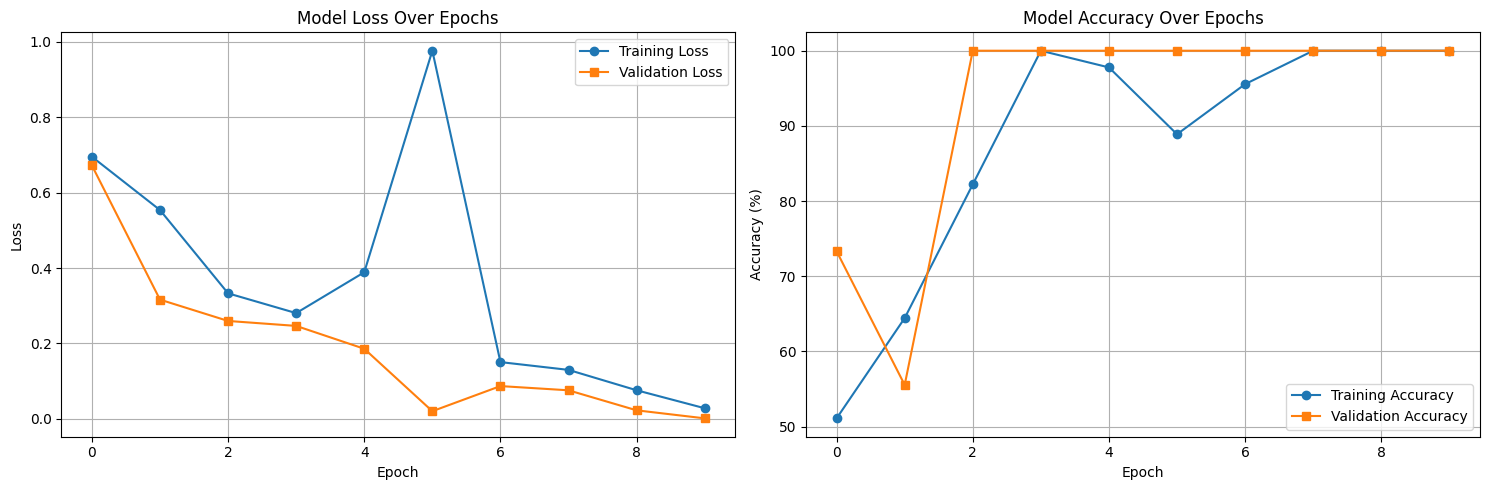

Final Training Metrics:- Final Training Loss: 0.0283- Final Validation Loss: 0.0015- Final Training Accuracy: 100.00%- Final Validation Accuracy: 100.00%Best Performance:- Best Epoch: 3- Best Validation Accuracy: 100.00%- Best Validation Loss: 0.2598

In [ ]:
# Task 9: Plot model training lossprint("Task 9 - Plotting model training loss and accuracy")# Create plotsfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))# Plot training and validation lossax1.plot(train_losses, label='Training Loss', marker='o')ax1.plot(val_losses, label='Validation Loss', marker='s')ax1.set_title('Model Loss Over Epochs')ax1.set_xlabel('Epoch')ax1.set_ylabel('Loss')ax1.legend()ax1.grid(True)# Plot training and validation accuracyax2.plot(train_accuracies, label='Training Accuracy', marker='o')ax2.plot(val_accuracies, label='Validation Accuracy', marker='s')ax2.set_title('Model Accuracy Over Epochs')ax2.set_xlabel('Epoch')ax2.set_ylabel('Accuracy (%)')ax2.legend()ax2.grid(True)plt.tight_layout()plt.show()# Print final metricsprint(f"\nFinal Training Metrics:")print(f" - Final Training Loss: {train_losses[-1]:.4f}")print(f" - Final Validation Loss: {val_losses[-1]:.4f}")print(f" - Final Training Accuracy: {train_accuracies[-1]:.2f}%")print(f" - Final Validation Accuracy: {val_accuracies[-1]:.2f}%")# Find best epochbest_epoch = np.argmax(val_accuracies)print(f"\nBest Performance:")print(f" - Best Epoch: {best_epoch + 1}")print(f" - Best Validation Accuracy: {val_accuracies[best_epoch]:.2f}%")print(f" - Best Validation Loss: {val_losses[best_epoch]:.4f}")

## Task 10: Retrieve predictions all_preds and ground truth all_labels from val_loader

Task 10 - Retrieving predictions and ground truth from val_loaderRetrieved predictions and ground truth:- all_preds shape: (45,)- all_labels shape: (45,)- all_preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 11 1 1 1 1 1 1 1]- all_labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 11 1 1 1 1 1 1 1]- Overall accuracy: 1.0000 (100.00%)- Correct predictions: 45/45Prediction breakdown:Sample 0: Predicted class_0_non_agri, True class_0_non_agri ✓Sample 1: Predicted class_0_non_agri, True class_0_non_agri ✓Sample 2: Predicted class_0_non_agri, True class_0_non_agri ✓Sample 3: Predicted class_0_non_agri, True class_0_non_agri ✓Sample 4: Predicted class_0_non_agri, True class_0_non_agri ✓Sample 5: Predicted class_0_non_agri, True class_0_non_agri ✓Sample 6: Predicted class_0_non_agri, True class_0_non_agri ✓Sample 7: Predicted class_0_non_agri, True class_0_non_agri ✓Sample 8: Predicted class_0_non_agri, True class_0_non_agri ✓Sample

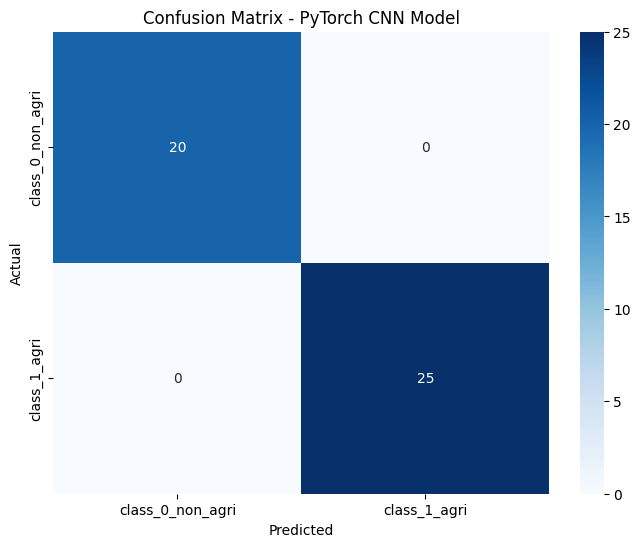

Task 10 completed - Retrieved all_preds and all_labels from val_loader

In [ ]:
# Task 10: Retrieve predictions all_preds and ground truth all_labels from val_loaderprint("Task 10 - Retrieving predictions and ground truth from val_loader")# Set model to evaluation modemodel.eval()# Initialize lists to store predictions and labelsall_preds = []all_labels = []# Get predictions from validation loaderwith torch.no_grad():for data, target in val_loader:data, target = data.to(device), target.to(device)# Forward passoutput = model(data)# Get predictions (class withhighest probability)_, predicted = torch.max(output, 1)# Store predictions and labelsall_preds.extend(predicted.cpu().numpy())all_labels.extend(target.cpu().numpy())# Convert to numpy arraysall_preds = np.array(all_preds)all_labels = np.array(all_labels)print(f"Retrieved predictions and ground truth:")print(f" - all_preds shape: {all_preds.shape}")print(f" - all_labels shape: {all_labels.shape}")print(f" - all_preds: {all_preds}")print(f" - all_labels: {all_labels}")# Calculate accuracyaccuracy = (all_preds == all_labels).mean()print(f" - Overall accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")# Count correct predictionscorrect = (all_preds == all_labels).sum()total = len(all_labels)print(f" - Correct predictions: {correct}/{total}")# Show prediction breakdownprint(f"\nPrediction breakdown:")for i in range(len(all_preds)):pred_class = val_dataset.classes[all_preds[i]]true_class = val_dataset.classes[all_labels[i]]correct_mark = "✓" if all_preds[i] == all_labels[i] else "✗"print(f" Sample {i}:Predicted {pred_class}, True {true_class} {correct_mark}")# Classification reportprint(f"\nClassification Report:")print(classification_report(all_labels, all_preds,target_names=val_dataset.classes))# Confusion matrixcm = confusion_matrix(all_labels, all_preds)plt.figure(figsize=(8, 6))sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=val_dataset.classes,yticklabels=val_dataset.classes)plt.title('Confusion Matrix - PyTorch CNN Model')plt.xlabel('Predicted')plt.ylabel('Actual')plt.show()print(f"\nTask 10 completed - Retrieved all_preds and all_labels from val_loader")